In [1]:
import torch
import numpy as np
import math
from torch import nn

In [2]:
max_degree = 20
n_train,n_test = 100,100

true_w = np.zeros(max_degree)

In [3]:
# according to exercise
true_w[0:4] = np.array([5,1.2,-3.4,5.6])

features = np.random.normal(size=(n_train+n_test,1))

In [4]:
np.random.shuffle(features)

In [5]:
np.arange(max_degree).reshape(1,-1)

array([[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15,
        16, 17, 18, 19]])

In [6]:
poly_features = np.power(features, np.arange(max_degree).reshape(1,-1))

In [7]:
for i in range(max_degree):
    poly_features[:,i] /= math.gamma(i+1) # gamma is (n-1)!

In [8]:
labels = np.dot( poly_features, true_w)
labels.shape

(200,)

In [9]:
# adding epsilon noise
labels += np.random.normal(scale=0.1, size=labels.shape)

# what we generated was

# y = 5 + 1.2 * x  - 3.4 * x^2/2! + 5.6 * x^3/3! + epsilon 

In [10]:
# converting to tensor
true_w,features,poly_features, labels = [torch.tensor(x, dtype=torch.float32) for x in [true_w, features, poly_features, labels]]

In [11]:
features[:2], poly_features[:2,:], labels[:2]

(tensor([[-1.1113],
         [-0.5267]]),
 tensor([[ 1.0000e+00, -1.1113e+00,  6.1746e-01, -2.2872e-01,  6.3543e-02,
          -1.4123e-02,  2.6157e-03, -4.1525e-04,  5.7682e-05, -7.1223e-06,
           7.9148e-07, -7.9960e-08,  7.4047e-09, -6.3298e-10,  5.0243e-11,
          -3.7223e-12,  2.5853e-13, -1.6900e-14,  1.0433e-15, -6.1023e-17],
         [ 1.0000e+00, -5.2673e-01,  1.3872e-01, -2.4356e-02,  3.2073e-03,
          -3.3787e-04,  2.9661e-05, -2.2319e-06,  1.4695e-07, -8.6004e-09,
           4.5301e-10, -2.1692e-11,  9.5215e-13, -3.8579e-14,  1.4515e-15,
          -5.0968e-17,  1.6779e-18, -5.1988e-20,  1.5213e-21, -4.2175e-23]]),
 tensor([0.2372, 3.8684]))

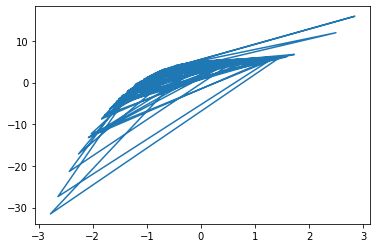

In [17]:
import  matplotlib.pyplot as plt

plt.plot(features, labels)

# complex polynomial

In [14]:
def evaluate_loss(net, data_iter, loss):
    total_loss = 0
    total_len = 0
    for X,y in data_iter:
        y_hat = net(X)
        y = y.reshape(y_hat)
        l = loss(y_hat, y)
        total_loss += l
        total_len += l.numel()
    
    return total_loss/total_len
        

In [19]:
class simpleDataset:
    def __init__(self, features, labels):
        self.features = features
        self.labels = labels
    
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, index):
        return self.features[index], self.labels[index]

train_dataset = simpleDataset(features[:n_train], labels[:n_train].reshape(-1,1))

X, y = train_dataset[0]

print(X)
print(y)
    

tensor([-1.1113])
tensor([0.2372])


In [20]:
def create_iter(features, labels, batch_size):
    return torch.utils.data.DataLoader(simpleDataset(features, labels), shuffle=True, batch_size=batch_size)

In [22]:
sample_iter = create_iter(features[:n_train], labels[:n_train].reshape(-1,1), 10)

for X,y in sample_iter:
    print(X.shape, y.shape)
    break

torch.Size([10, 1]) torch.Size([10, 1])


In [23]:
def evaluate_loss(net, data_iter, loss, text):
    total_loss = 0
    total_number = 0
    with torch.no_grad():
        for X, y in data_iter:
            y_hat = net(X)
            l =  loss(y_hat, y)
            total_loss += l
            total_number += y.numel()
    print(f"{text} loss is : {total_loss/total_number}")
    return total_loss/total_number

In [43]:
def train(train_features, train_labels, test_features, test_labels, num_epochs=400):
    loss = nn.CrossEntropyLoss()
    input_shape = train_features.shape[-1]
    print(f"input feature size is : {input_shape}")
    net = nn.Sequential(nn.Linear(input_shape,1, bias=False))
    batch_size = min(10, train_labels.shape[0])
    train_iter = create_iter(train_features, train_labels.reshape(-1,1), batch_size)
    test_iter = create_iter(test_features, test_labels.reshape(-1,1), batch_size)
    
    optimizer = torch.optim.SGD(net.parameters(), lr=0.01)
    
    # training loop
    
    for epoch in range(num_epochs):
        for X, y in train_iter:
            y_hat = net(X)
#             print(y_hat.shape)
            print(y, y_hat)
            l = loss(y_hat, y)
            optimizer.zero_grad()
            l.backward()
            
            optimizer.step()
        
        print(f"Last batch loss for epoch {epoch} is {l.detach()}")
        evaluate_loss(net, train_iter, loss, "train")
        evaluate_loss(net, test_iter, loss, "test")
    
    print("weight : ", net[0].weight.data.numpy())
    

In [44]:
# fitting third order polynomial function fitting

train(poly_features[:n_train, :4], labels[:n_train], poly_features[n_train:, :4], labels[n_train:])

input feature size is : 4
tensor([[2.8379],
        [5.0012],
        [6.2424],
        [4.9530],
        [5.2848],
        [5.4610],
        [5.1605],
        [5.1390],
        [5.2267],
        [5.5065]]) tensor([[0.1813],
        [0.3178],
        [0.0270],
        [0.3195],
        [0.3196],
        [0.3112],
        [0.3203],
        [0.3201],
        [0.3221],
        [0.1639]], grad_fn=<MmBackward>)


RuntimeError: 1D target tensor expected, multi-target not supported